In [1]:
import torch
import torch.nn as nn
import nussl
from nussl.datasets import transforms as nussl_tfm
from nussl.ml.networks.modules import BatchNorm, RecurrentStack, Embedding, STFT, LearnedFilterBank, AmplitudeToDB
from models.MaskInference import MaskInference
from models.UNet import UNetSpect
from models.Filterbank import Filterbank
from utils import utils, data, viz
from pathlib import Path
import yaml, argparse
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
#Load yaml configs into configs dictionary
with open('config/test_auto.yml','r') as f:
    configs = yaml.safe_load(f)
    f.close()

In [3]:
utils.logger()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

stft_params = nussl.STFTParams(**configs['stft_params'])

tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])

if configs['model_type'] == 'Filterbank':
    stft_params=None

configs['batch_size'] = 1
configs['train_generator_params']['num_mixtures']=10
configs['valid_generator_params']['num_mixtures']=1

duration=5

train_data = data.on_the_fly(stft_params, transform=tfm, fg_path=configs['test_folder'], **configs['train_generator_params'], duration=duration)
train_dataloader = torch.utils.data.DataLoader(train_data, num_workers=1, batch_size=configs['batch_size'])

val_data = data.on_the_fly(stft_params, transform=tfm, fg_path=configs['test_folder'], **configs['valid_generator_params'], duration=duration)
val_dataloader = torch.utils.data.DataLoader(val_data, num_workers=1, batch_size=configs['batch_size'])

In [4]:
overfit_selection=1

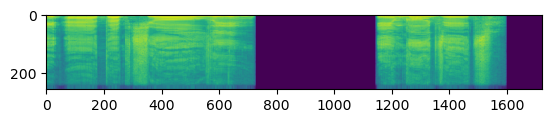

In [5]:
plt.imshow(np.log(train_data[overfit_selection]['source_magnitudes'].squeeze().detach().numpy().T+1e-10))

In [6]:
loss_type = configs['loss_type']
loss_dict = {'L1': nussl.ml.train.loss.L1Loss,
             'L2': nussl.ml.train.loss.MSELoss,
             'MSE': nussl.ml.train.loss.MSELoss,}
assert loss_type in loss_dict.keys(), f'Loss type must be one of {loss_dict.keys()}'
loss_fn = loss_dict[loss_type]()

In [7]:
def train_step(engine, batch):
    optimizer.zero_grad()
    
    #Forward pass
    output = model(batch)
    loss = loss_fn(output['estimates'],batch['source_magnitudes'])
    
    #Backward pass
    loss.backward()
    optimizer.step()
    
    loss_vals = {'loss':loss.item()}
    
    return loss_vals

def val_step(engine, batch):
    with torch.no_grad():
        output = model(batch)
    loss = loss_fn(output['estimates'],batch['source_magnitudes'])  
    loss_vals = {'loss':loss.item()}
    return loss_vals

In [8]:
model_type = configs['model_type']
model_dict = {'Mask': MaskInference,
              'UNet': UNetSpect,
              'Filterbank':Filterbank
             }
assert model_type in model_dict.keys(), f'Model type must be one of {model_dict.keys()}'
#Set up the model and optimizer
if model_type=='Mask':
    model = MaskInference.build(stft_params.window_length//2+1, **configs['model_params']).to(device)
elif model_type=='UNet':
    model = UNetSpect.build(**configs['model_params']).to(device)
elif model_type=='Filterbank':
    model = Filterbank.build(128, **configs['model_params']).to(device)

optimizer = torch.optim.Adam(model.parameters(), **configs['optimizer_params'])

In [9]:
for i,batch in enumerate(train_dataloader):
    if i==overfit_selection:
        batch=batch
        break
    
for key in batch:
    if torch.is_tensor(batch[key]):
        batch[key] = batch[key].float().to(device)   

In [10]:
batch['mix_magnitude'].shape

torch.Size([1, 1724, 257, 1])

In [11]:
configs['optimizer_params']['lr'] = 1e-2

In [12]:
# Create nussl ML engine
trainer, validator = nussl.ml.train.create_train_and_validation_engines(train_step, val_step, device=device)

In [13]:
N_ITERATIONS = 200
loss_history = [] # For bookkeeping

for i in range(N_ITERATIONS):
    loss_val = train_step(trainer,batch)
    loss_history.append(loss_val['loss'])
    if i%20==0:
        print(f'Loss: {loss_val["loss"]:.6f} at iteration {i}')

Loss: 0.000877 at iteration 0
Loss: 0.000522 at iteration 20
Loss: 0.000328 at iteration 40
Loss: 0.000238 at iteration 60
Loss: 0.000201 at iteration 80
Loss: 0.000181 at iteration 100
Loss: 0.000169 at iteration 120
Loss: 0.000160 at iteration 140
Loss: 0.000153 at iteration 160
Loss: 0.000148 at iteration 180


In [14]:
configs['train_params']['epoch_length']=2
configs['optimizer_params']['lr'] = 1e-10

# Save model outputs
checkpoint_folder = Path('overfit').absolute()

# Adding handlers from nussl that print out details about model training
# run the validation step, and save the models.
nussl.ml.train.add_stdout_handler(trainer, validator)
nussl.ml.train.add_validate_and_checkpoint(checkpoint_folder, model, optimizer, train_data, trainer, val_dataloader, validator)
nussl.ml.train.add_progress_bar_handler(trainer, validator)

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [15]:
trainer.run(train_dataloader, **configs['train_params'])

04/27/2023 10:57:35 AM | engine.py:874 Engine run starting with max_epochs=1.
Iteration: [2/2] 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████, avg_loss=0.00106 [00:01<00:00]04/27/2023 10:57:38 AM | engine.py:874 Engine run starting with max_epochs=1.

[1/1] 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [00:00<?]
Iteration: [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [00:00<?]
Iteration: [1/1] 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████, avg_loss=0.00104 [00:00<?]
                                                                                                                                    

State:
	iteration: 2
	epoch: 1
	epoch_length: 2
	max_epochs: 1
	output: <class 'dict'>
	batch: <class 'dict'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	epoch_history: <class 'dict'>
	iter_history: <class 'dict'>
	past_iter_history: <class 'dict'>
	saved_model_path: /SFS/user/ry/stonekev/audio/audio_isolation/overfit/checkpoints/best.model.pth
	output_folder: <class 'pathlib.PosixPath'>

In [16]:
target = batch['source_magnitudes'][0].squeeze().detach().numpy()
output = model(batch)
estimates = output['estimates'][0].squeeze().detach().numpy()

/tmp/ipykernel_10833/3767737487.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(target.T))


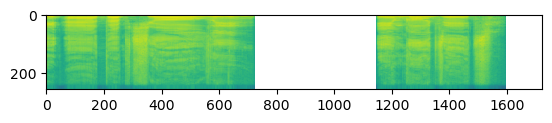

In [17]:
plt.imshow(np.log(target.T))

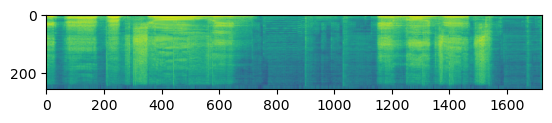

In [18]:
plt.imshow(np.log(estimates.T))

In [19]:
print(np.max(target))
print(np.max(estimates))

print(np.min(target))
print(np.min(estimates))

print(np.std(target))
print(np.std(estimates))

0.14343983
0.1394544
0.0
4.9284295e-11
0.00455351
0.0043140925


In [20]:
#Load in the model
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path='overfit/checkpoints/latest.model.pth',
    device='cpu',
)

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


In [21]:
#Test on the data
test_folder = configs['test_folder']
tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
])
test_data = data.mixer(stft_params, transform=tfm, fg_path=configs['train_folder'], num_mixtures=1, coherent_prob=1.0, duration=5)

test_data = data.on_the_fly(stft_params, transform=None, fg_path=configs['test_folder'], **configs['train_generator_params'], duration=duration)

In [22]:
signal = test_data[1]['mix']
signal.embed_audio()

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/SFS/user/ry/stonekev/miniconda3/envs/audio --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpo

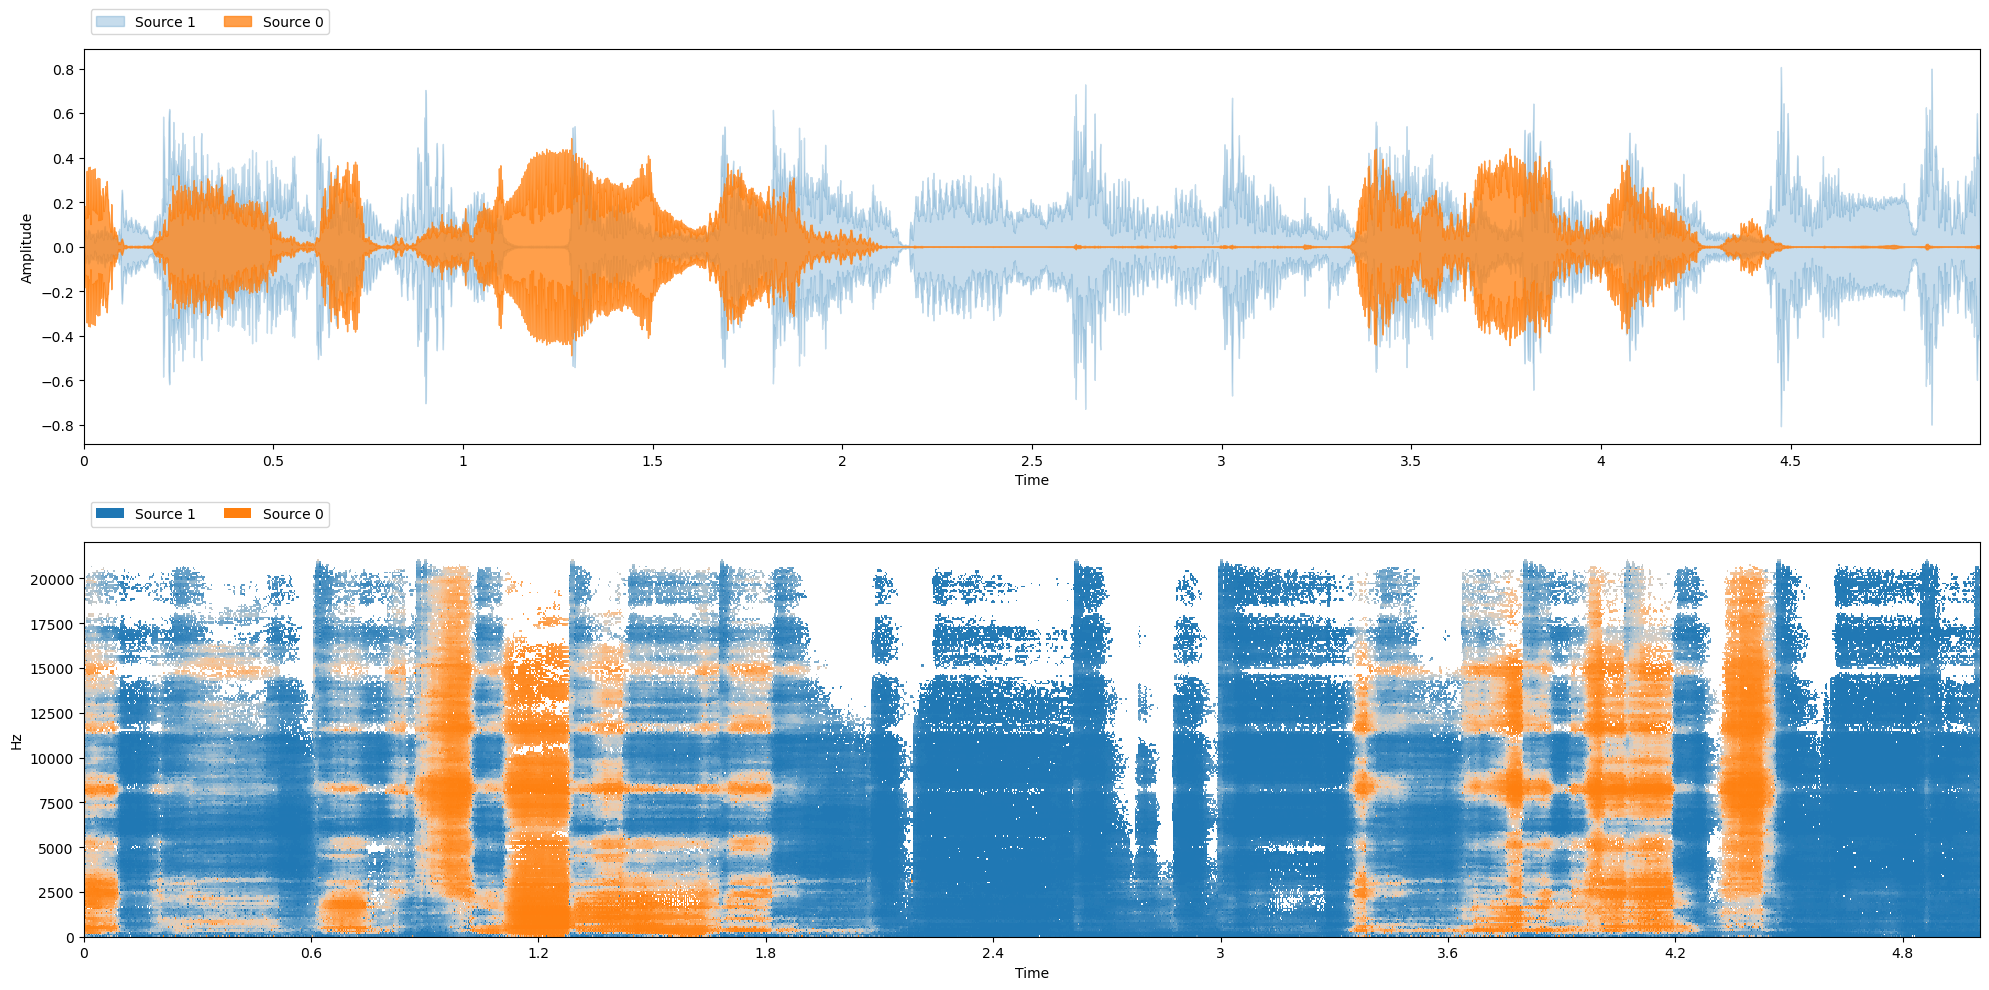


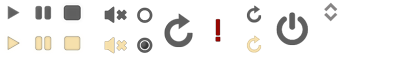
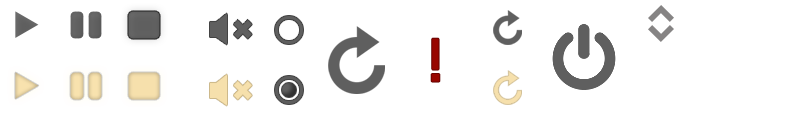
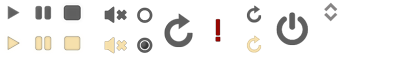

In [23]:
separator.audio_signal = signal
estimates = separator()
estimates.append(signal - estimates[0])

viz.show_sources(estimates)